In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os, psutil
import timeit

## Building the dataset

In [2]:
input_dataset_path = './input_dataset'
output_dataset_path = './output_dataset'

! rm -r ./output_dataset
! mkdir -p ./output_dataset/covid
! mkdir -p ./output_dataset/normal

In [3]:
n_samples = 50

#### Build covid dataset

In [4]:
covid_dataset_path = os.path.sep.join([input_dataset_path, "covid19_xray_image_2"])

# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])

covid_meta_df = pd.read_csv(csvPath)

# loop over the rows of the COVID-19 data frame
for (i, row) in covid_meta_df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{output_dataset_path}/covid", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

#### Build normal dataset

In [5]:
pneumonia_dataset_path = os.path.sep.join([input_dataset_path, "chest_xray_1"])

basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:n_samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{output_dataset_path}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

## Plot x-rays

some helpers to how us the raw images

In [6]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [7]:
normal_images = list(paths.list_images(f"{output_dataset_path}/normal"))
covid_images = list(paths.list_images(f"{output_dataset_path}/covid"))

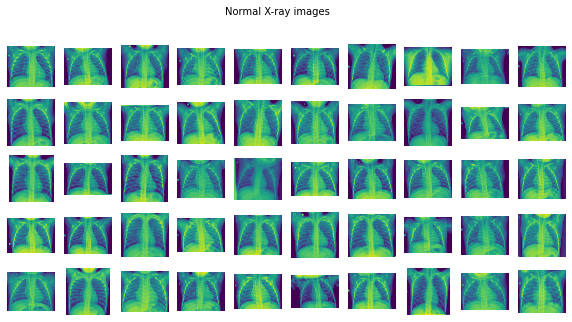

In [8]:
plots_from_files(normal_images, rows=5, maintitle="Normal X-ray images")

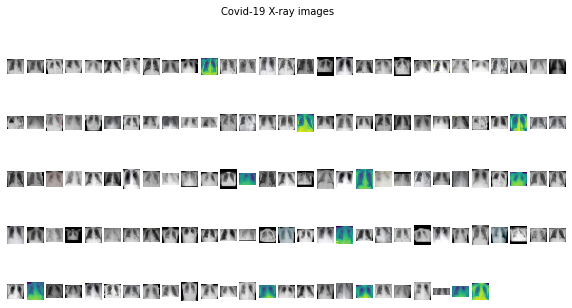

In [9]:
plots_from_files(covid_images, rows=5, maintitle="Covid-19 X-ray images")

## Images processing

We will take one image to show image processing steps, and then we will apply these steps to all images

In [10]:
# helper function to plot two images for comparison
def plot_two_images(im1, im2, title1='', title2=''):
    fig=plt.figure(figsize=(8, 8))
    
    fig.add_subplot(1, 2, 1)
    plt.title(title1)
    plt.imshow(im1, cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.title(title2)
    plt.imshow(im2, cmap='gray')

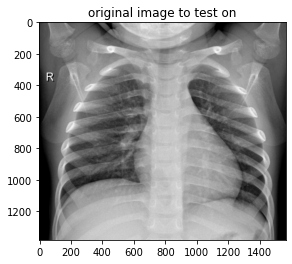

In [11]:
imagePaths = list(paths.list_images(output_dataset_path))

img = cv2.imread(imagePaths[0])

plt.title('original image to test on')
plt.imshow(img)

### Resizing down the image

I'll be using images of size (224, 224)

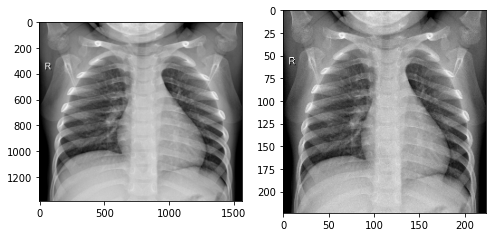

In [12]:
resized_img = cv2.resize(img, (224, 224))

plot_two_images(img, resized_img)

### Enhancing contrast

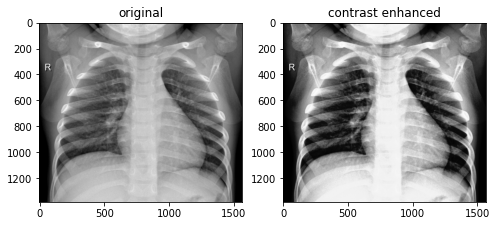

In [13]:
xp = [0, 64, 128, 192, 255]
fp = [0, 16, 128, 240, 255]
x = np.arange(256)
table = np.interp(x, xp, fp).astype('uint8')
contrasted_img = cv2.LUT(img, table)

plot_two_images(img, contrasted_img, 'original', 'contrast enhanced')

This shows more details of the image that before

### Sharpening the image

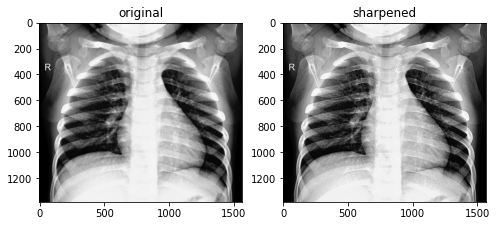

In [14]:
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpened_img = cv2.filter2D(contrasted_img, -1, kernel)

plot_two_images(contrasted_img, sharpened_img, 'original', 'sharpened')

### Edges detection

There are several kinds of edge detection, here is some of them

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


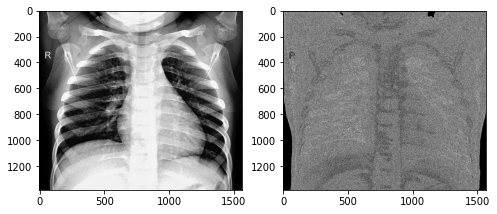

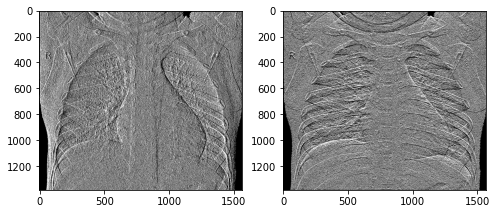

In [15]:
laplacian = cv2.Laplacian(sharpened_img,cv2.CV_64F)
sobelx = cv2.Sobel(sharpened_img,cv2.CV_64F,1,0,ksize=5)  # x
sobely = cv2.Sobel(sharpened_img,cv2.CV_64F,0,1,ksize=5)  # y

plot_two_images(sharpened_img, laplacian)
plot_two_images(sobelx, sobely)

### Combination to help function

In [16]:
xp = [0, 64, 128, 192, 255]
fp = [0, 16, 128, 240, 255]
x = np.arange(256)
CONTRAST_TABLE = np.interp(x, xp, fp).astype('uint8')

SHARP_KERNEL = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])


def process_image(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to a format the NN can deal with
    img = cv2.LUT(img, CONTRAST_TABLE)
    img = cv2.filter2D(img, -1, SHARP_KERNEL)
    
    img = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    
    return img

### Applying to all images

In [17]:
imagePaths = list(paths.list_images(output_dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = process_image(image)
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

## Machine learning

As a final step, I used CNN to predict the labels of the images

In [18]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=0)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [19]:
# load the VGG16 network, this model is pretrained to classify images, as we don't want to spend a lot of time
# in building a new model from scratch
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
# layers:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [20]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 5
BS = 8

In [21]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/5
19/19 [==============================] - 67s 4s/step - loss: 0.8010 - accuracy: 0.6104 - val_loss: 0.3448 - val_accuracy: 0.9744
Epoch 2/5
19/19 [==============================] - 72s 4s/step - loss: 0.4244 - accuracy: 0.8554 - val_loss: 0.1822 - val_accuracy: 0.9744
Epoch 3/5
19/19 [==============================] - 66s 3s/step - loss: 0.2593 - accuracy: 0.9279 - val_loss: 0.1248 - val_accuracy: 1.0000
Epoch 4/5
19/19 [==============================] - 66s 4s/step - loss: 0.2539 - accuracy: 0.9384 - val_loss: 0.0874 - val_accuracy: 0.9744
Epoch 5/5
19/19 [==============================] - 65s 3s/step - loss: 0.1688 - accuracy: 0.9578 - val_loss: 0.0713 - val_accuracy: 1.0000


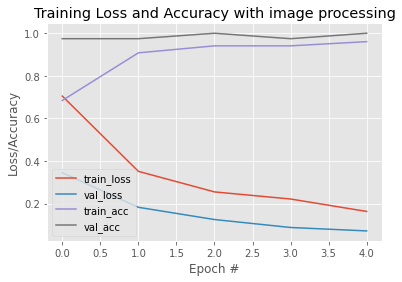

In [24]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy with image processing")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot_with_image_processing.png")

## Conclusion

The value of the image processing we did is that we get to a high accuracy score very fast, here in only 4 ephocs (the 5th did not change the score).